## Keypoint Detection
---
There are 10 images given in the ***img*** folder. Your task is to detect ***200*** keypoints for each of them using detectors.

Recommend to use SIFT in [opencv-python](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html) to detect keypoints.

Let's take a look at these images first!

---

In [21]:
# load packages
import cv2
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

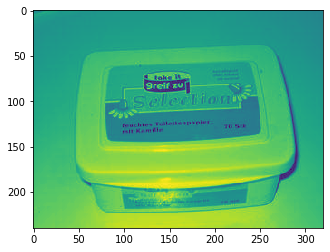

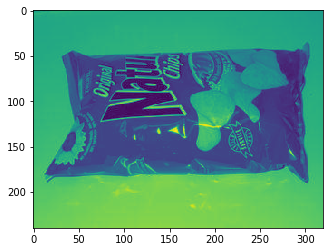

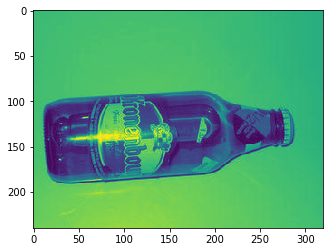

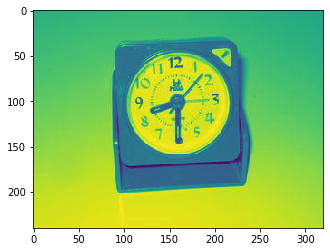

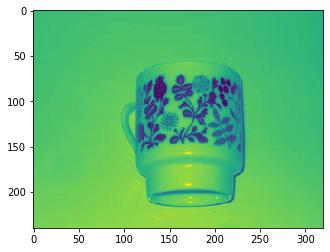

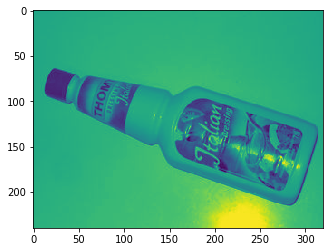

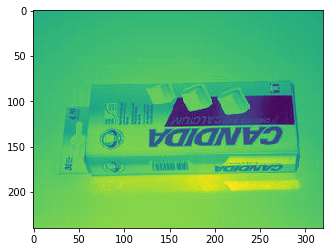

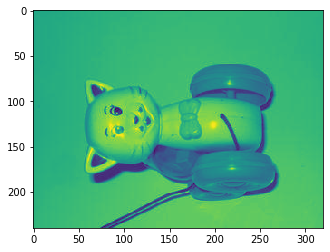

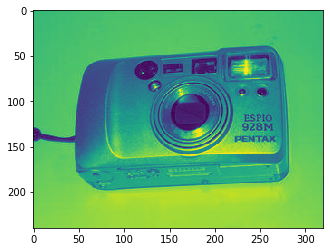

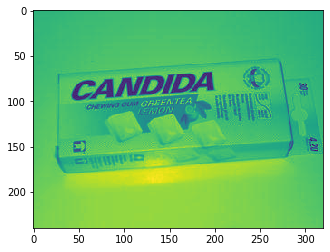

In [6]:
img_dir = "image_retrieval/query"

if os.path.exists(img_dir):
    if os.listdir(img_dir) is []:
        print("No images!")
        exit(0)
    num_img = len(os.listdir(img_dir))
    count = 0
    for img in os.listdir(img_dir):
        if count == 10:
            break
        if not img.endswith("JPG"):
            continue
        image_dir = os.path.join(img_dir, img)
        image = cv2.imread(image_dir)
        gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        plt.imshow(gray)
        plt.show()
        count += 1
        
else:
    print("image folder not exists!")
    exit(0)

### The Keypoints:
The output of this part is a list of keypoints that represented by the x and y cooridnates.

You also can store these keypoints locations into a tensor, so that the tensor for all of these 10 images will have the size of [10, 200, 2]. Here we use a python list as illustration.

For example, the 10 points of image ***NotreDame5.jpg*** are:

Then we can obtain the patches with these keypoints:


In [22]:
def getPatches(kps, img, size=32, num=20):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)
#         res[i, 0, xmin_res: xmax_res, ymin_res: ymax_res] = img[ymin: ymax, xmin: xmax]
        res[i, 0, ymin_res: ymax_res, xmin_res: xmax_res] = img[ymin: ymax, xmin: xmax]
    return res

### Let's plot these patches

In [28]:
all_patches = []
all_keypoints = []
for i in range(1,35):
    # ---------------key points-----------------------
    img = cv2.imread('image_retrieval/query/' + 'q' + str(i) +'.JPG')
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create(20)
    #sift = cv2.SIFT()
    kp = sift.detect(gray,None)

    img=cv2.drawKeypoints(gray,kp,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    sift = cv2.xfeatures2d.SIFT_create(20)
    kp, des = sift.detectAndCompute(gray,None)
    keypoints = torch.tensor([cv2.KeyPoint_convert(kp)])
    if len(keypoints[0]) == 21:
        keypoints = keypoints[0][:-1].view(1,20,2)
    if len(keypoints[0]) == 22:
        keypoints = keypoints[0][:-2].view(1,20,2)
    # ------------------------------------------------
    kp.sort(key=lambda x:x.response, reverse=True)
    patch_size = 32
    patch = getPatches(keypoints[0], gray,size=patch_size, num=len(keypoints[0]))
    keypoints = keypoints.view(20,2)
#     print(keypoints.shape)
    all_keypoints.append(keypoints)
#     for idx,patch in enumerate(patch):
#         im = patch[0].numpy()
#         plt.imshow(im)
#         plt.show()
#         if idx == 0:
#             break
    all_patches.append(patch)
patches = torch.stack(all_patches)
kps = torch.stack(all_keypoints)
print(patches.shape)
print(kps.shape)

torch.Size([34, 20, 1, 32, 32])
torch.Size([34, 20, 2])


In [33]:
sift = cv2.xfeatures2d.SIFT_create(600)
img_dir = "image_retrieval/images"
kps_num = 20
img_num = 136
patch_size = 32
res_kps = torch.zeros(img_num, kps_num, 2)
res_pts = torch.zeros(img_num, kps_num, 1, patch_size, patch_size)
for idx in range(img_num):
    image_dir = os.path.join(img_dir, "{}.JPG".format(idx+1))
    if not os.path.exists(image_dir):
        print("image {} not exists".format(image_dir))
    image = cv2.imread(image_dir)
    img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    ## find the keypoints and descriptors with SIFT, need to sort based on the response
    kps, des = sift.detectAndCompute(img, None)
    kps.sort(key=lambda x:x.response, reverse=True)
    
    ## remove duplicate
    temp = set()
    kps = [x for x in kps if x.pt not in temp and not temp.add(x.pt)]
    
    keypoints_img = [kps[a].pt for a in range(kps_num)] 
    res_kps[idx] = torch.FloatTensor(keypoints_img)
    
    ## extract patches
    res_pts[idx] = getPatches(keypoints_img, img, size=patch_size, num=kps_num)
print(res_pts.shape)
print(res_kps.shape)

torch.Size([136, 20, 1, 32, 32])
torch.Size([136, 20, 2])


### Save the patches with PyTorch
For each image, you can output the patches within one tensor. In above examples, tensor ***patches*** is the one that you should store in a list. And then save the list as a "patches.pt" file:

In [34]:
output_dir = "patches_image.pt"
output_kps = "keypoints_image.pth"
torch.save(res_pts, output_dir)
torch.save(res_kps, output_kps)

### Test with your saved patches

In [35]:
patches = torch.load(output_dir)
print(type(patches))
print(patches.shape)

<class 'torch.Tensor'>
torch.Size([136, 20, 1, 32, 32])
